# Day 33 Analysis

I'm refreshing the analysis from Day 11 where I built a simple model for expected weekly PPR points for WRs based on target share. I'm updating the data through Week 11 to see if there are any players that stand out for the last 6 games of the season.

## Set Up

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Target Share vs. PPR Fantasy Points: 1999-2021
First I'll get the average target share and PPR fantasy points scored by WRs for seasons 1999-2021 (Weeks 1-8). Then I'll fit a regression line to the data which will be used to generate expected PR fantasy points for the 2022 season.

### Get Data

In [3]:
query = """
WITH data AS (
    SELECT
        player_id,
        season,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points_ppr AS pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season <> 2022
        AND week <= 11
), aggregation AS (
    SELECT
        player_name,
        season,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(pts_ppr) AS avg_pts_ppr
    FROM data
    GROUP BY player_id, player_name, season
)
SELECT *
FROM aggregation
"""

df_by_player_season_1999_2021 = pd.read_sql(query, conn)
print(df_by_player_season_1999_2021.shape)
df_by_player_season_1999_2021.head()


(4025, 5)


,player_name,season,num_games,avg_tgt_share,avg_pts_ppr
0,Derrick Alexander,1999,10,0.233358,11.760000
1,Derrick Alexander,2000,9,0.250518,18.033333
2,Derrick Alexander,2001,7,0.175425,7.085714
3,Derrick Alexander,2002,8,0.124326,4.175000
4,Reidel Anthony,1999,8,0.209992,7.125000


### Clean Data

In [18]:
# Check for number of games played
# If number of game played = 1, can create noise. Will want to remove
print(df_by_player_season_1999_2021['num_games'].value_counts(normalize=True).sort_index())

df_by_player_season_1999_2021 = df_by_player_season_1999_2021.query('num_games > 1')
print(df_by_player_season_1999_2021.shape)

2     0.085950
3     0.072176
4     0.067493
5     0.074931
6     0.073278
7     0.077410
8     0.096694
9     0.127548
10    0.306336
11    0.018182
Name: num_games, dtype: float64
(3630, 5)


### Exploratory Analysis

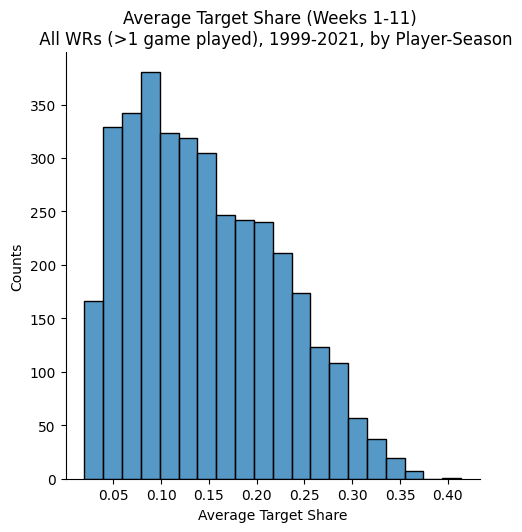

In [19]:
# Check distribution
g = sns.displot(
    x="avg_tgt_share",
    data=df_by_player_season_1999_2021,
    kind="hist",
    bins=20
)

g.set(
    xlabel="Average Target Share", 
    ylabel="Counts",
    title="Average Target Share (Weeks 1-11) \n All WRs (>1 game played), 1999-2021, by Player-Season"
)

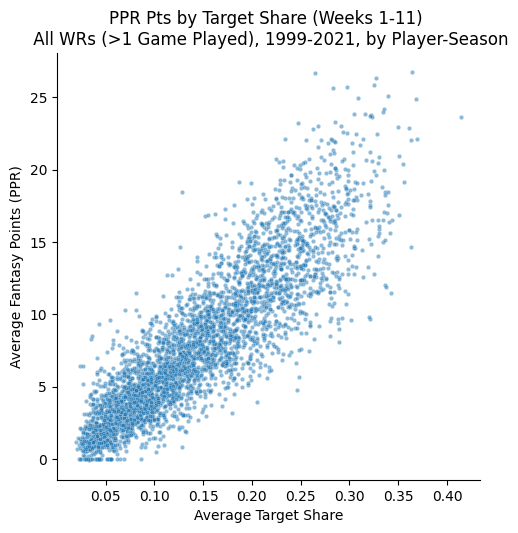

In [21]:
g = sns.relplot(
    x="avg_tgt_share",
    y="avg_pts_ppr",
    data=df_by_player_season_1999_2021,
    alpha=0.5,
    s=10
)

g.set(
    xlabel="Average Target Share", 
    ylabel="Average Fantasy Points (PPR)",
    title="PPR Pts by Target Share (Weeks 1-11) \n All WRs (>1 Game Played), 1999-2021, by Player-Season"
)

In [7]:
print(f"Correlation Coefficient: {df_by_player_season_1999_2021['avg_tgt_share'].corr(df_by_player_season_1999_2021['avg_pts_ppr']).round(3)}")

Correlation Coefficient: 0.877


### Run Regression

In [8]:
# Fit a regression line
fit = np.polyfit(
    x=df_by_player_season_1999_2021['avg_tgt_share'], 
    y=df_by_player_season_1999_2021['avg_pts_ppr'], 
    deg=1)

lin_func_fpts = np.poly1d(fit)

In [9]:
# Use regression equation to get expected fantasy points for the 2022 season

# Get data
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points_ppr AS pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season = 2022
        AND week <= 11
), aggregation AS (
    SELECT
        player_name,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(pts_ppr) AS avg_pts_ppr
    FROM data
    GROUP BY player_id, player_name
)
SELECT *
FROM aggregation
"""

df_by_player_2022 = pd.read_sql(query, conn)

# Create summary table
summary_2022 = df_by_player_2022.sort_values('avg_pts_ppr', ascending=False).reset_index(drop=True) # index = fantasy points ranking
summary_2022.index = summary_2022.index + 1 # easier to read (1 is now top player by avg fantasy points)

summary_2022 = summary_2022.sort_values('avg_tgt_share', ascending=False)

summary_2022['avg_pts_expected'] = lin_func_fpts(summary_2022['avg_tgt_share'])
summary_2022['avg_pts_diff'] = summary_2022['avg_pts_ppr'] - summary_2022['avg_pts_expected']

print(summary_2022.shape)
summary_2022.head(10).round(3)


(204, 6)


,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
4,Davante Adams,10,0.327,21.640,18.617,3.023
6,DeAndre Hopkins,5,0.324,21.140,18.480,2.660
11,CeeDee Lamb,10,0.313,16.430,17.809,-1.379
2,Cooper Kupp,9,0.306,22.378,17.402,4.975
3,Tyreek Hill,10,0.303,22.230,17.220,5.010
1,Stefon Diggs,10,0.291,22.730,16.498,6.232
13,A.J. Brown,10,0.290,16.150,16.463,-0.313
5,Justin Jefferson,10,0.286,21.552,16.257,5.295
15,Amon-Ra St. Brown,9,0.284,15.644,16.138,-0.494
45,D.J. Moore,11,0.278,10.373,15.776,-5.404


Based on the regression line fit on 1999-2021 player-season data, D.J. Moore is scoring 5.4 PPR fantasy points **less than expected**, per week – a good candidate for positive regression given his high target share. When I ran this model on Week 8 data Stefon Diggs was at 8.5 PPR pts over expectation per week – now he has dropped to 6.2.  

CeeDee Lamb is still a candidate for a slight positive regression – pretty remarkable given his increased scoring the past few weeks.  

To see how likely it is for a player to regress to the mean, I will look at the distribution of `avg_points_diff` and if normal, will use statistical methods to determine probability.

In [10]:
# Sort by the difference between actual points and expected points to get the true "regression to the mean" candidates
# Remove players with only 1 game played as that can be considered noise
bottom_5_2022 = summary_2022[summary_2022['num_games'] > 1] \
    .sort_values('avg_pts_diff', ascending=True) \
    .round(3)

pd.concat([bottom_5_2022.head(), bottom_5_2022[-5:]])

,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
61,Darnell Mooney,11,0.270,9.227,15.287,-6.060
57,Drake London,11,0.266,9.445,15.037,-5.591
86,Robert Woods,10,0.222,6.950,12.519,-5.569
45,D.J. Moore,11,0.278,10.373,15.776,-5.404
122,Equanimeous St. Brown,9,0.173,4.589,9.611,-5.022
5,Justin Jefferson,10,0.286,21.552,16.257,5.295
9,Jaylen Waddle,10,0.213,17.450,11.958,5.492
10,Michael Thomas,3,0.201,17.033,11.273,5.760
37,Mecole Hardman,8,0.103,11.725,5.570,6.155
1,Stefon Diggs,10,0.291,22.730,16.498,6.232


After Week 8 I called out Darnell Mooney as a positive regression candidate and he is doing a little better, scoring only 6 pts less than expected per week compared to 7.8 pts less in my original analysis. However, given that Justin Fields dealing with a shoulder injury, I doubt his numbers will improve much.

## Analyze Average Points Differential

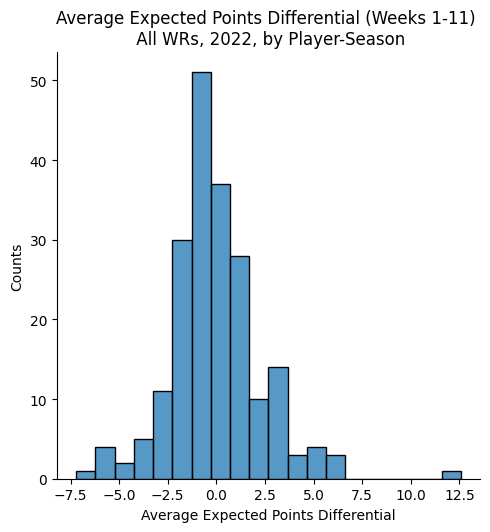

In [24]:
g = sns.displot(
    x='avg_pts_diff',
    data=summary_2022,
    kind="hist",
    bins=20
)

g.set(
    xlabel="Average Expected Points Differential", 
    ylabel="Counts",
    title="Average Expected Points Differential (Weeks 1-11) \n All WRs, 2022, by Player-Season"
)

The distribution looks like a normal distribution with mean around 0. Next I'll get average points differential on the 1999-2021 population to confirm.

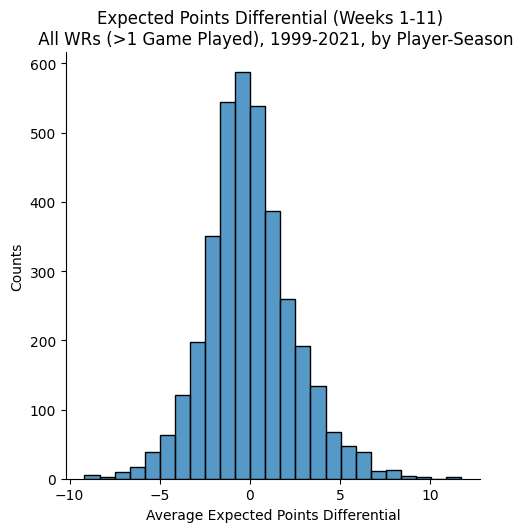

In [33]:
# Use regression line on original dataset with all values 
df_by_player_season_1999_2021['avg_pts_expected'] = lin_func_fpts(df_by_player_season_1999_2021['avg_tgt_share'])
df_by_player_season_1999_2021['avg_pts_diff'] = df_by_player_season_1999_2021['avg_pts_ppr'] - df_by_player_season_1999_2021['avg_pts_expected']

g = sns.displot(
    x='avg_pts_diff',
    data=df_by_player_season_1999_2021,
    kind="hist",
    bins=25
)

g.set(
    xlabel="Average Expected Points Differential", 
    ylabel="Counts",
    title="Expected Points Differential (Weeks 1-11) \n All WRs (>1 Game Played), 1999-2021, by Player-Season"
)

The population distribution confirms that average points differential is normally distributed with a mean of approximately 0.

In [26]:
summary_2022['avg_pts_diff'].describe()

count    204.000000
mean      -0.011181
std        2.403900
min       -7.213602
25%       -1.298798
50%       -0.312822
75%        1.172463
max       12.572201
Name: avg_pts_diff, dtype: float64

In [27]:
df_by_player_season_1999_2021['avg_pts_diff'].describe().apply(lambda x: format(x, 'f'))

count    3630.000000
mean        0.000000
std         2.447473
min        -9.176371
25%        -1.489278
50%        -0.152661
75%         1.347560
max        11.732928
Name: avg_pts_diff, dtype: object

The observed expected points differential from 1999-2021 is normally distributed with a mean of 0 and standard deviation of 2.45. Therefore we would expect the sample population of player averages for 2022 to be normally distributed as well and thus we should be able to compute the likelihood of a player finishing with that expected point differential (actual - expected) using statistical methods. 

In [28]:
def cdf_player_2022(df, df_current_season, player_name):
    """
    Return the probability of <= a player's expected point differential given:
    df: the dataset we want to get the probability from
    df_current_season: the dataset where we want to get a player's expected point differential
    player_name: name of player in df_current_season
    """
    cdf = scipy.stats.norm(
            df['avg_pts_diff'].mean(),
            df['avg_pts_diff'].std()
            ).cdf(df_current_season[df_current_season['player_name'] == player_name]['avg_pts_diff'])
    return round((cdf[0] * 100),2)

def pdf_player_2022(df, df_current_season, player_name):
    """
    Return the probability of a player's expected point differential given:
    df: the dataset we want to get the probability from
    df_current_season: the dataset where we want to get a player's expected point differential
    player_name: name of player in df_current_season
    """
    pdf = scipy.stats.norm(
            df['avg_pts_diff'].mean(),
            df['avg_pts_diff'].std()
            ).pdf(df_current_season[df_current_season['player_name'] == player_name]['avg_pts_diff'])
    return round((pdf[0] * 100),2)

The pdf function calculates the probability of X for a given value of X. In this case, we are looking at the probability of a player having an average points differential of X for a given value of X (target share).

In [30]:
pdf_player_2022(df_by_player_season_1999_2021, summary_2022, 'D.J. Moore')

1.42

Going back to D.J. Moore, using the normal distribution of average points differential, I calculate a 1.42% chance of scoring 5.4 points less than expected per week given his  nearly 28% target share. If this is the case, D.J. Moore should perform well the second half of the season. I know he's up against a tough Denver defense in Week 12 but Carolina has a bye Week 13 and then Pittsburgh and Detroit Weeks 15 and 16, respectively. If managers can just hold on odds are D.J. Moore can be a league-winner.